In [5]:
## Impor Area
import numpy as np
import torch
from piq import ssim
from Util.pyDialogue import *

from image_similarity_measures.quality_metrics import fsim, issm, sam, ssim, uiq, psnr
from sewar import full_ref as sfr

from skimage.io import imread
import matplotlib.pyplot as plt

import os
import glob

In [6]:
torch.cuda.is_available()

True

In [7]:
## Load data
files_SL = glob.glob("../../../Paper Prep/Data_additional/Density_proxy/grays/predictions_SL/*.npy")
files_WU = glob.glob("../../../Paper Prep/Data_additional/Density_proxy/grays/predictions_WU/*.npy")

assert len(files_SL) == len(files_WU)
print("Number of files: ", len(files_SL))

Number of files:  14


In [8]:
## Laod reference
reference = glob.glob("../../../Paper Prep/Data_additional/Density_proxy/grays/*.png")

assert len(reference) == len(files_SL) == len(files_WU)
print(f"Number of reference images: {len(reference)}")

Number of reference images: 14


In [12]:
## Adjust size of images
# As we are only looking at the same image size in segmentation and original, but they dont match in size, we need to adjust the size of the images

print(f"Size Reference: {imread(reference[0]).shape}")
print(f"Size SL: {np.load(files_SL[0]).shape}")
print(f"Difference in size: {np.array(imread(reference[0]).shape) - np.array(np.load(files_SL[0]).shape)}")

# We need to cut the images to the size of the segmentation
# We do this by cutting the reference images

reference_slice_max = np.array(imread(reference[0]).shape[:2]) - np.array(np.load(files_SL[0]).shape[:2])
print(f"Max slice: {reference_slice_max}")

## For easier comparison, we will pick two special reference images
# These are the 100% case in both ground truth and reconstruction
ground_truth_ref = reference[-1]
recreation_ref_SL = files_SL[-1]
recreation_ref_WU = files_WU[-1]
print(f"Ground truth path:\t{ground_truth_ref}")
print(f"Recreation path SL:\t{recreation_ref_SL}")
print(f"Recreation path WU:\t{recreation_ref_WU}")

Size Reference: (3392, 3392, 3)
Size SL: (3328, 3328, 3)
Difference in size: [64 64  0]
Max slice: [64 64]
Ground truth path:	../../../Paper Prep/Data_additional/Density_proxy/grays\6069_50Hz_1_fullLOCS_10nm_grey.png
Recreation path SL:	../../../Paper Prep/Data_additional/Density_proxy/grays/predictions_SL\6069_50Hz_1_fullLOCS_10nm_grey.npy
Recreation path WU:	../../../Paper Prep/Data_additional/Density_proxy/grays/predictions_WU\6069_50Hz_1_fullLOCS_10nm_grey.npy


In [6]:
## Assign reference

chosen_reference = 

eval_dict_SL = {
    os.path.basename(reference[i]).split("_")[3]:(imread(reference[-1])[:-reference_slice_max[0], :-reference_slice_max[1], 0].astype(np.uint16), np.load(files_SL[i])[...,0].astype(np.uint16)) 
    for i in range(len(files_SL)) 
    if os.path.basename(reference[i]).split("_")[3] == os.path.basename(files_SL[i]).split("_")[3]
    }
eval_dict_WU = {
    os.path.basename(reference[i]).split("_")[3]:(imread(reference[-1])[:-reference_slice_max[0], :-reference_slice_max[1], 0].astype(np.uint16), np.load(files_WU[i])[...,1].astype(np.uint16)) 
    for i in range(len(files_WU)) 
    if os.path.basename(reference[i]).split("_")[3] == os.path.basename(files_WU[i]).split("_")[3]
    }

(-0.5, 3327.5, 3327.5, -0.5)

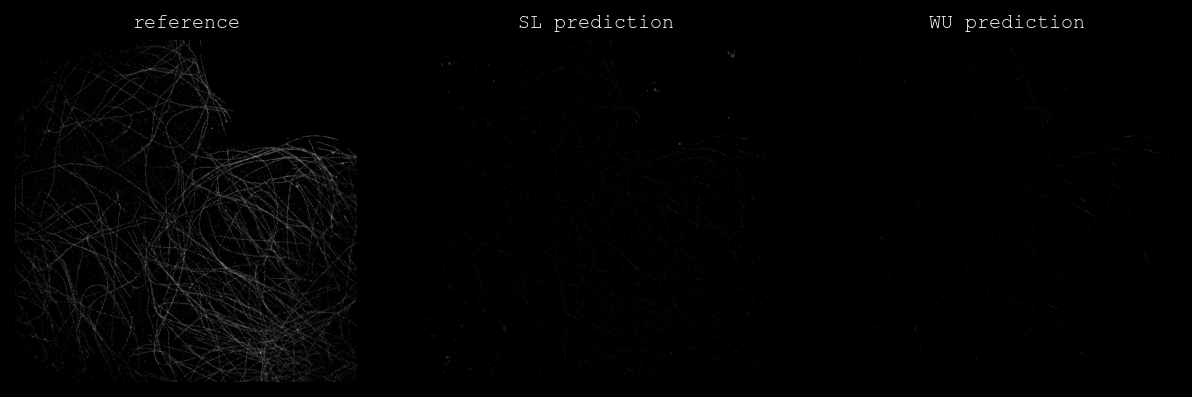

In [13]:
## Let's take a look at the images
# Just a quick sanity check

plt.style.use('dark_background')
font = {'family' : 'Courier new',
        'weight' : 'bold',
        'size'   : 8}
plt.rc('font', **font)


ID:int = 8
key = list(eval_dict_SL.keys())[ID]

fig, axs = plt.subplots(1, 3, figsize=(10, 5), dpi = 150)

axs[0].set_title('reference')
axs[0].imshow(eval_dict_SL[key][0], cmap="gray")
axs[0].axis("off")

axs[1].set_title('SL prediction')
axs[1].imshow(eval_dict_SL[key][1], cmap="gray")
axs[1].axis("off")

axs[2].set_title('WU prediction')
axs[2].imshow(eval_dict_WU[key][1], cmap="gray")
axs[2].axis("off")

In [8]:
## Evaluate
from tqdm.notebook import tqdm
results_SL = {key:{"msssim":sfr.msssim(eval_dict_SL[key][0],eval_dict_SL[key][1], MAX = 255),
                     "ssim":ssim(eval_dict_SL[key][0], eval_dict_SL[key][1], max_p=255)}
                  for key in tqdm(eval_dict_SL.keys())}

results_WU = {key:{"msssim":sfr.msssim(eval_dict_WU[key][0],eval_dict_WU[key][1], MAX = 255),
                     "ssim":ssim(eval_dict_WU[key][0], eval_dict_WU[key][1], max_p=255)}
                  for key in tqdm(eval_dict_WU.keys())}

  0%|          | 0/14 [00:00<?, ?it/s]

c:\Users\belav\AppData\Local\Programs\Python\Python39\lib\site-packages\image_similarity_measures\quality_metrics.py:197: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return structural_similarity(org_img, pred_img, data_range=max_p, multichannel=True)


  0%|          | 0/14 [00:00<?, ?it/s]

In [9]:
## Since the nomenclature was not ideally chosen, we need to sort the dictionary post hoc
# To that end, we will use the follwoing list which is the order of the images in the paper
sort_list = ['05perc', '1perc', '3perc', '5perc', '10perc', '20perc', '30perc', '40perc', '50perc', '60perc', '70perc', '80perc', '90perc', 'fullLOCS']

# Sort the dictionaries
results_SL = {key:results_SL[key] for key in sort_list}
results_WU = {key:results_WU[key] for key in sort_list}

# We can also transalte the keys to more mathematical notation
results_SL = {key.replace("perc", "%"):results_SL[key] for key in sort_list}
results_WU = {key.replace("perc", "%"):results_WU[key] for key in sort_list}

C:\Users\belav\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\belav\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


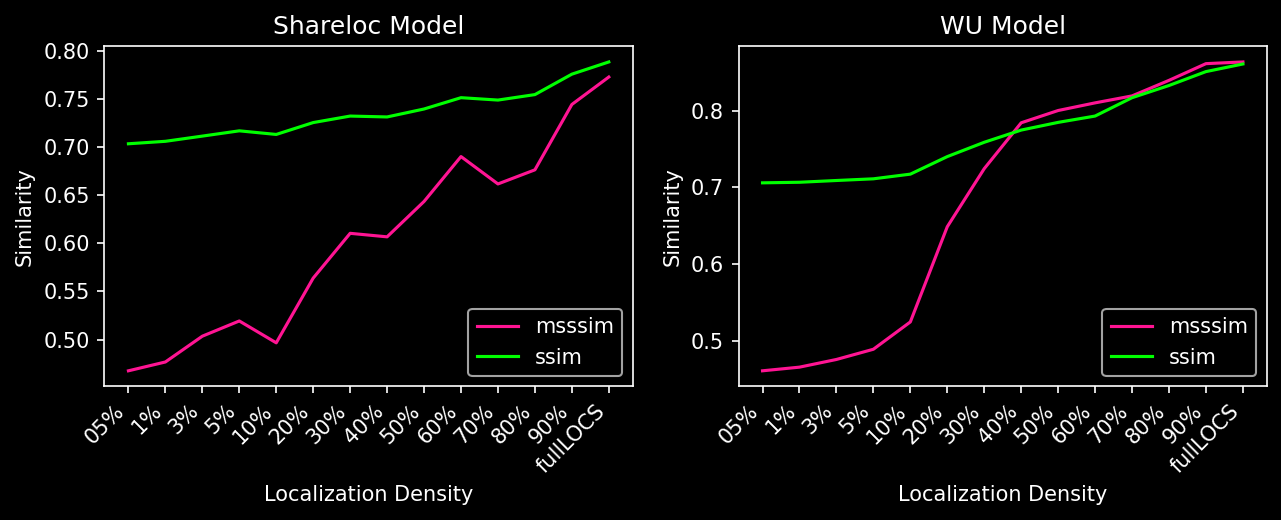

In [10]:
## Now we can compare the results in graphs

plt.style.use('dark_background')
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 10}
plt.rc('font', **font)

fig, axs = plt.subplots(1, 2, figsize=(10, 3), dpi = 150)

axs[0].set_title('Shareloc Model')
axs[0].plot(list(results_SL.keys()), [results_SL[key]["msssim"] for key in results_SL.keys()], label = "msssim", color = "deeppink")
axs[0].plot(list(results_SL.keys()), [results_SL[key]["ssim"] for key in results_SL.keys()], label = "ssim", color = "lime")
axs[0].legend(loc="lower right")
axs[0].set_xlabel("Localization Density")
axs[0].set_ylabel("Similarity")

axs[1].set_title('WU Model')
axs[1].plot(list(results_WU.keys()), [results_WU[key]["msssim"] for key in results_WU.keys()], label = "msssim", color = "deeppink")
axs[1].plot(list(results_WU.keys()), [results_WU[key]["ssim"] for key in results_WU.keys()], label = "ssim", color = "lime")
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Localization Density")
axs[1].set_ylabel("Similarity")


for label in axs[0].get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')
for label in axs[1].get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

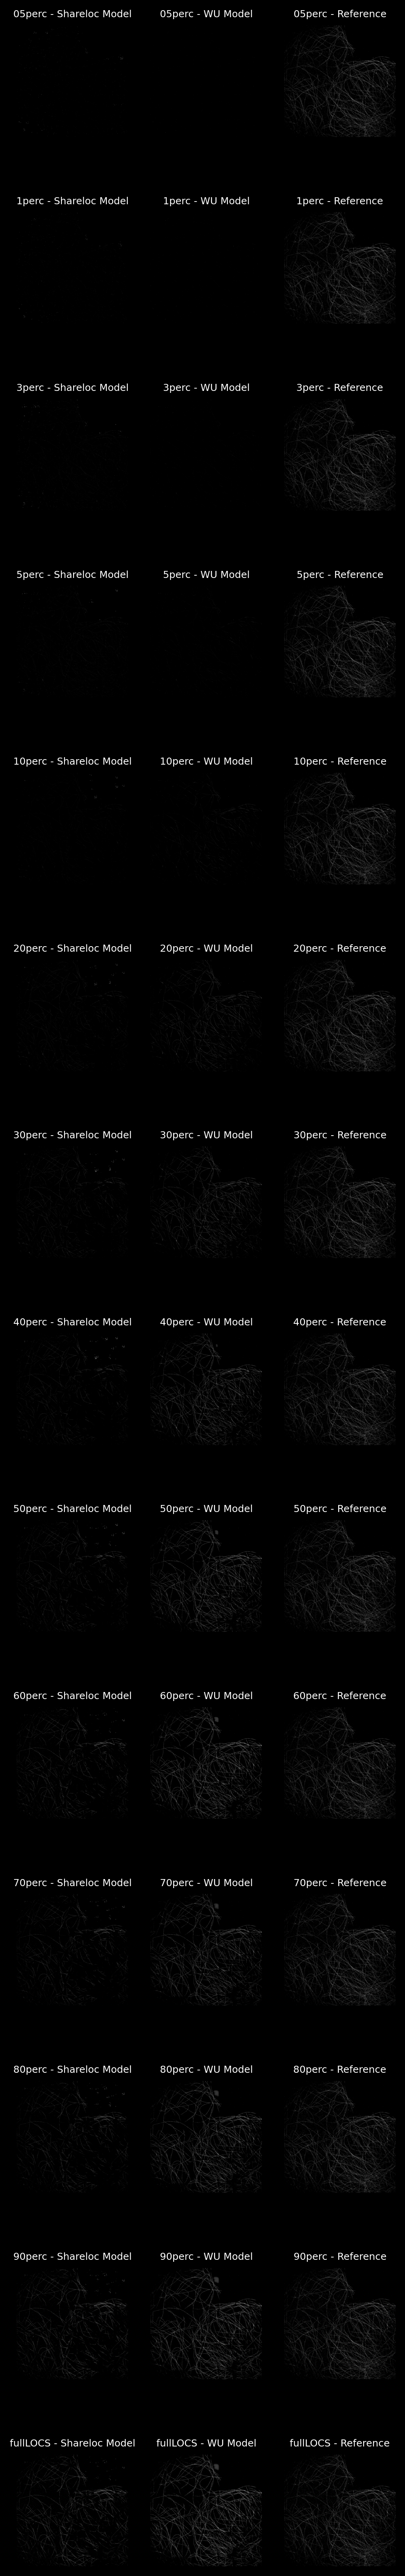

In [11]:
## Finally, let's just plot the entire predictions in one big Figure
# We will use the same order as in the paper

plt.style.use('dark_background')
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 6}
plt.rc('font', **font)

fig, axs = plt.subplots(14, 4, figsize=(8, 35), dpi = 250)

for i, key in enumerate(sort_list):
    axs[i,0].set_title(f'{key} - Shareloc Model')
    axs[i,0].imshow(eval_dict_SL[key][1], cmap="gray")
    axs[i,0].axis("off")

    axs[i,1].set_title(f'{key} - WU Model')
    axs[i,1].imshow(eval_dict_WU[key][1], cmap="gray")
    axs[i,1].axis("off")
    
    axs[i,2].set_title(f'{key} - Reference')
    axs[i,2].imshow(eval_dict_SL[key][0], cmap="gray")
    axs[i,2].axis("off")